In [61]:
import numpy as np
import matplotlib.pyplot as plt

OMEGA_RAD = 28.984 * np.pi / 180

donaghadee_data = np.array([
    [0.716667,3.61],      # Wed, High
    [6.766667,0.78],      # Wed, Low
    [12.83333,4.01],      # Wed, High
    [19.283333,0.59],     # Wed, Low
    [25.25,3.61],         # Thu, High
    [31.4,0.75],           # Thu, Low
    [37.43333,4.06],      # Thu,High
    [43.9,0.56],          # Thu, Low
    [49.916667,3.62],      # Fri, High
    [56.033333,0.73],      # Fri, Low
    [62.116667,4.08],     # Fri, High
    [68.55,0.55],         # Fri, Low
    [74.63333,3.61],       # Sat, High
    [80.7166667,0.74],     # Sat, Low
    [86.85,4.05],         # Sat, High
    [93.266667,0.59],      #Sat, Low
    [99.4167 ,3.58],       # Sun, High
    [105.45,0.79],        # Sun, Low
    [111.65,4.96],         # Sun, High
    [118.0667,0.69],      #Sun, Low
    [124.2833,3.51],       # Mon, High
    [130.3,0.88],         # Mon, Low
    [136.55,3.79],         # Mon, High
    [143.0167,0.83]      #Mon, Low
])

bristol_data = np.array([
    [3.25,2.06],       # Wed, Low
    [8.8,12.55],       # Wed, High
    [15.616667,1.96],   # Wed, Low
    [21.15,12.36],      # Wed, High
    [27.788333,2.08],    # Thu, Low
    [33.4,12.58],        # Thu, High
    [40.15,1.96],       # Thu, Low
    [45.716667,12.39],  # Thu, High
    [52.23333,2.05],     # Fri, Low
    [57.966667,12.56],   # Fri, High
    [64.6,1.94],        # Fri, Low
    [70.3,12.33],       # Fri, High
    [76.7,2.02],         # Sat, Low
    [82.58333,12.42],   # Sat, High
    [89.083333,1.97],   # Sat, Low
    [94.916667,12.11],  # Sat, High
    [101.25, 2.12],      # Sun, Low
    [107.25, 12.06],     # Sun, High
    [113.666667, 2.19],  # Sun, Low
    [119.6, 11.66],      # Sun, High
    [125.883333, 2.47],  # Mon, Low
    [132.033333, 11.47], # Mon, High
    [138.366667, 2.67],  # Mon, Low
    [144.4, 11]     # Tues, High
])

omegas_deg = np.array([
    28.9841042,   # M2
    30.0000000,   # S2
    15.0410686,   # K1
    # 13.9430356,   # O1
    # 14.9589314,   # P1
    # 28.4397295,   # N2
    # 57.9682084    # M4
])
manual_omegas = omegas_deg * np.pi / 180

In [ ]:
# values function
def tide_params(data, omega):
  times = data[:, 0]
  heights = data[:, 1]

  n = len(times)
  A = np.zeros((n, 3))

  for i in range(n):
      A[i, 0] = 1
      A[i, 1] = np.cos(omega * times[i])
      A[i, 2] = np.sin(omega * times[i])

  A_transpose = A.T
  ATA = A_transpose @ A
  ATA_inv = np.linalg.inv(ATA)
  ATb = A_transpose @ heights
  params = ATA_inv @ ATb
  return params

# Predicted height function
def predicted(t, params, omega):
  h0, a, b = params
  return h0 + a * np.cos(omega * t) + b * np.sin(omega * t)

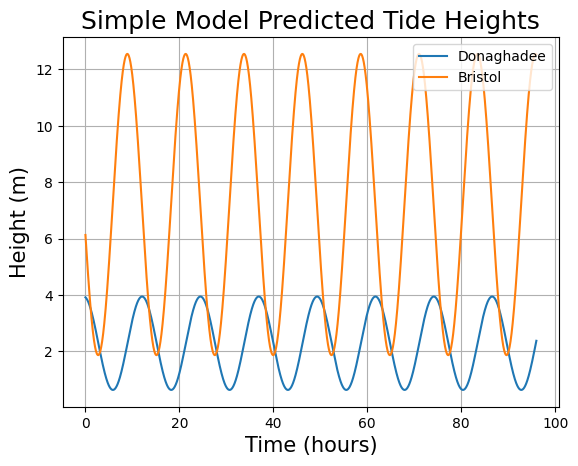

In [ ]:
import matplotlib.pyplot as plt

plot_times = np.linspace(0, 96, 4000)
donaghadee_params = tide_params(donaghadee_data, OMEGA_RAD)
bristol_params = tide_params(bristol_data, OMEGA_RAD)

donaghadee_plots = [predicted(t, donaghadee_params, OMEGA_RAD) for t in plot_times]
bristol_plots = [predicted(t, bristol_params, OMEGA_RAD) for t in plot_times]

plt.plot(plot_times, donaghadee_plots, label='Donaghadee')
plt.plot(plot_times, bristol_plots, label='Bristol')
plt.xlabel('Time (hours)', fontsize=15)
plt.ylabel('Height (m)', fontsize=15)
plt.title('Simple Model Predicted Tide Heights', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=10)
plt.savefig("PreditedTideHeights.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
import requests
from datetime import datetime

def dataExtraction(dates, station_id):
    times = []
    heights = []

    url = f"https://environment.data.gov.uk/flood-monitoring/id/stations/{station_id}/readings"

    # Reference start time = first day of first range at midnight
    y0, m0, d0_start, _ = dates[0]
    t0 = datetime(y0, m0, d0_start)

    for year, month, start_day, end_day in dates:
        for day in range(start_day, end_day + 1):
            print(f"Fetching station {station_id} data for {year}-{month:02d}-{day:02d}...")

            params = {
                "date": f"{year}-{month:02d}-{day:02d}",
                "_sorted": ""
            }

            response = requests.get(url, params=params)
            response.raise_for_status()

            items = response.json().get("items", [])

            for reading in items:
                t = datetime.fromisoformat(
                    reading["dateTime"].replace("Z", "")
                )

                decimal_hour = (t - t0).total_seconds() / 3600
                times.append(decimal_hour)
                heights.append(reading["value"])

    return np.array(times), np.array(heights)

Fetching station E72639 data for 2026-01-21...
Fetching station E72639 data for 2026-01-22...
Fetching station E72639 data for 2026-01-23...
Fetching station E72639 data for 2026-01-24...
Fetching station E72639 data for 2026-01-25...
Fetching station E72639 data for 2026-01-26...
Fetching station E72639 data for 2026-01-27...


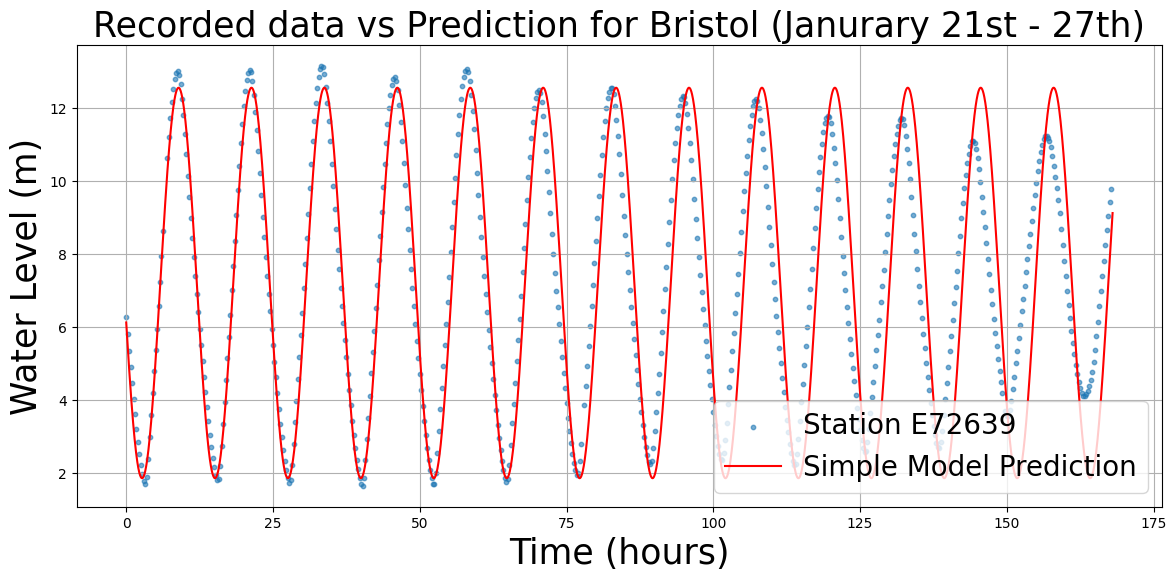

In [ ]:
fourdays_times, fourdays_heights = dataExtraction([(2026, 1, 21, 27)], "E72639")
adjusted_heights = fourdays_heights + 7.230865 - 0.78478929

plot_times = np.linspace(0, 168, 4000)
bristol_params = tide_params(bristol_data, OMEGA_RAD)
bristol_plots = [predicted(t, bristol_params, OMEGA_RAD) for t in plot_times]

plt.figure(figsize=(14, 6))
plt.scatter(fourdays_times, adjusted_heights, s=10, alpha=0.6, label='Station E72639')
plt.plot(plot_times, bristol_plots, color='red', label='Simple Model Prediction')
plt.xlabel('Time (hours)',fontsize=25)
plt.ylabel('Water Level (m)',fontsize=25)
plt.title('Recorded data vs Prediction for Bristol (Janurary 21st - 27th)',fontsize=25)
plt.grid(True)
plt.legend(loc='lower right',fontsize=20)
plt.savefig("BristolDataVsRecorded.pdf", format="pdf", bbox_inches="tight")
plt.show()

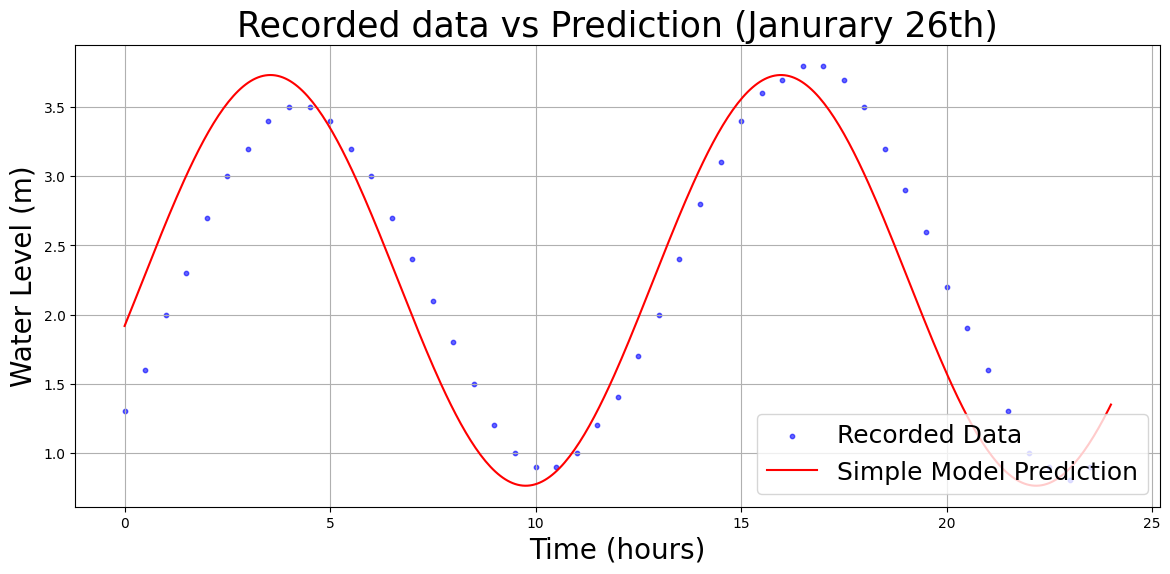

In [ ]:
#donaghadee

#26th of January
donaghadee_times = [
    0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
    4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5,
    8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5,
    12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5,
    16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5,
    20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5
]

donaghadee_heights = [
    1.3, 1.6, 2.0, 2.3, 2.7, 3.0, 3.2, 3.4,
    3.5, 3.5, 3.4, 3.2, 3.0, 2.7, 2.4, 2.1,
    1.8, 1.5, 1.2, 1.0, 0.9, 0.9, 1.0, 1.2,
    1.4, 1.7, 2.0, 2.4, 2.8, 3.1, 3.4, 3.6,
    3.7, 3.8, 3.8, 3.7, 3.5, 3.2, 2.9, 2.6,
    2.2, 1.9, 1.6, 1.3, 1.0, 0.9, 0.8, 0.9
]

Jan_26_plot_times = np.linspace(120, 144, 400)
donaghadee_Jan_plots = [predicted(t, donaghadee_params, OMEGA_RAD) for t in Jan_26_plot_times]
plot_times = np.linspace(0, 24, 400)

plt.figure(figsize=(14, 6))
plt.scatter(donaghadee_times, donaghadee_heights, color="blue", s=10, alpha=0.6, label='Recorded Data')
plt.plot(plot_times, donaghadee_Jan_plots, color='red', label='Simple Model Prediction')
plt.xlabel('Time (hours)', fontsize=20)
plt.ylabel('Water Level (m)', fontsize=20)
plt.title('Recorded data vs Prediction (Janurary 26th)', fontsize=25)
plt.grid(True)
plt.legend(loc='lower right', fontsize=18)
plt.savefig("DonaghadeeDataVsRecorded.pdf", format="pdf", bbox_inches="tight")
plt.show()

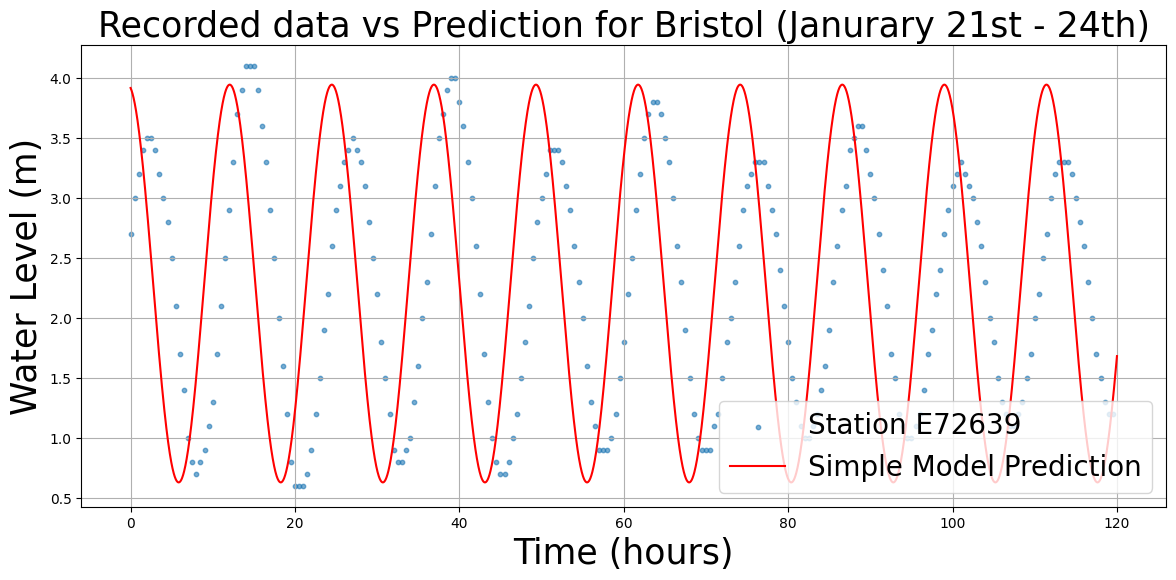

In [ ]:
donaghadee_times = np.arange(0, 120, 0.5)
donaghadee_heights = np.array([
    # Day 1
    2.7, 3.0, 3.2, 3.4, 3.5, 3.5, 3.4, 3.2,
    3.0, 2.8, 2.5, 2.1, 1.7, 1.4, 1.0, 0.8,
    0.7, 0.8, 0.9, 1.1, 1.3, 1.7, 2.1, 2.5,
    2.9, 3.3, 3.7, 3.9, 4.1, 4.1, 4.1, 3.9,
    3.6, 3.3, 2.9, 2.5, 2.0, 1.6, 1.2, 0.8,
    0.6, 0.6, 0.6, 0.7, 0.9, 1.2, 1.5, 1.9,

    # Day 2
    2.2, 2.6, 2.9, 3.1, 3.3, 3.4, 3.5, 3.4,
    3.3, 3.1, 2.8, 2.5, 2.2, 1.8, 1.5, 1.2,
    0.9, 0.8, 0.8, 0.9, 1.0, 1.3, 1.6, 2.0,
    2.3, 2.7, 3.1, 3.5, 3.7, 3.9, 4.0, 4.0,
    3.8, 3.6, 3.3, 3.0, 2.6, 2.2, 1.7, 1.3,
    1.0, 0.8, 0.7, 0.7, 0.8, 1.0, 1.2, 1.5,

    # Day 3
    1.8, 2.1, 2.5, 2.8, 3.0, 3.2, 3.4, 3.4,
    3.4, 3.3, 3.1, 2.9, 2.6, 2.3, 2.0, 1.6,
    1.3, 1.1, 0.9, 0.9, 0.9, 1.0, 1.2, 1.5,
    1.8, 2.2, 2.5, 2.9, 3.2, 3.5, 3.7, 3.8,
    3.8, 3.7, 3.5, 3.3, 3.0, 2.6, 2.3, 1.9,
    1.5, 1.2, 1.0, 0.9, 0.9, 0.9, 1.1, 1.2,

    # Day 4
    1.5, 1.8, 2.0, 2.3, 2.6, 2.9, 3.1, 3.2,
    3.3, 3.3, 3.3, 3.1, 2.9, 2.7, 2.4, 2.1,
    1.8, 1.5, 1.3, 1.1, 1.0, 1.0, 1.1, 1.2,
    1.4, 1.6, 1.9, 2.3, 2.6, 2.9, 3.1, 3.4,
    3.5, 3.6, 3.6, 3.4, 3.2, 3.0, 2.7, 2.4,
    2.1, 1.7, 1.5, 1.2, 1.1, 1.0, 1.0, 1.1,

    # Day 5
    1.2, 1.4, 1.7, 1.9, 2.2, 2.4, 2.7, 2.9,
    3.1, 3.2, 3.3, 3.2, 3.1, 3.0, 2.8, 2.6,
    2.3, 2.0, 1.8, 1.5, 1.3, 1.2, 1.1, 1.1,
    1.2, 1.3, 1.5, 1.7, 2.0, 2.2, 2.5, 2.7,
    3.0, 3.2, 3.3, 3.3, 3.3, 3.2, 3.0, 2.8,
    2.6, 2.3, 2.0, 1.7, 1.5, 1.3, 1.2, 1.2
])

plot_times = np.linspace(0, 120, 4000)
donaghadee_params = tide_params(donaghadee_data, OMEGA_RAD)
donaghadee_plots = [predicted(t, donaghadee_params, OMEGA_RAD) for t in plot_times]

plt.figure(figsize=(14, 6))
plt.scatter(donaghadee_times, donaghadee_heights, s=10, alpha=0.6, label='Station E72639')
plt.plot(plot_times, donaghadee_plots, color='red', label='Simple Model Prediction')
plt.xlabel('Time (hours)',fontsize=25)
plt.ylabel('Water Level (m)',fontsize=25)
plt.title('Recorded data vs Prediction for Bristol (Janurary 21st - 24th)',fontsize=25)
plt.grid(True)
plt.legend(loc='lower right',fontsize=20)
plt.savefig("BristolDataVsRecorded.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
bristol_times, bristol_heights = dataExtraction([(2026, 1, 7, 31), (2026, 2, 1, 5)], "E72639")

Fetching station E72639 data for 2026-01-07...
Fetching station E72639 data for 2026-01-08...
Fetching station E72639 data for 2026-01-09...
Fetching station E72639 data for 2026-01-10...
Fetching station E72639 data for 2026-01-11...
Fetching station E72639 data for 2026-01-12...
Fetching station E72639 data for 2026-01-13...
Fetching station E72639 data for 2026-01-14...
Fetching station E72639 data for 2026-01-15...
Fetching station E72639 data for 2026-01-16...
Fetching station E72639 data for 2026-01-17...
Fetching station E72639 data for 2026-01-18...
Fetching station E72639 data for 2026-01-19...
Fetching station E72639 data for 2026-01-20...
Fetching station E72639 data for 2026-01-21...
Fetching station E72639 data for 2026-01-22...
Fetching station E72639 data for 2026-01-23...
Fetching station E72639 data for 2026-01-24...
Fetching station E72639 data for 2026-01-25...
Fetching station E72639 data for 2026-01-26...
Fetching station E72639 data for 2026-01-27...
Fetching stat

In [ ]:
bangor_times, bangor_heights = dataExtraction([(2026, 1, 7, 31), (2026, 2, 1, 5)], "E73839")

Fetching station E73839 data for 2026-01-07...
Fetching station E73839 data for 2026-01-08...
Fetching station E73839 data for 2026-01-09...
Fetching station E73839 data for 2026-01-10...
Fetching station E73839 data for 2026-01-11...
Fetching station E73839 data for 2026-01-12...
Fetching station E73839 data for 2026-01-13...
Fetching station E73839 data for 2026-01-14...
Fetching station E73839 data for 2026-01-15...
Fetching station E73839 data for 2026-01-16...
Fetching station E73839 data for 2026-01-17...
Fetching station E73839 data for 2026-01-18...
Fetching station E73839 data for 2026-01-19...
Fetching station E73839 data for 2026-01-20...
Fetching station E73839 data for 2026-01-21...
Fetching station E73839 data for 2026-01-22...
Fetching station E73839 data for 2026-01-23...
Fetching station E73839 data for 2026-01-24...
Fetching station E73839 data for 2026-01-25...
Fetching station E73839 data for 2026-01-26...
Fetching station E73839 data for 2026-01-27...
Fetching stat

In [ ]:
barmouth_times, barmouth_heights = dataExtraction([(2026, 1, 7, 31), (2026, 2, 1, 5)], "E73239")

Fetching station E73239 data for 2026-01-07...
Fetching station E73239 data for 2026-01-08...
Fetching station E73239 data for 2026-01-09...
Fetching station E73239 data for 2026-01-10...
Fetching station E73239 data for 2026-01-11...
Fetching station E73239 data for 2026-01-12...
Fetching station E73239 data for 2026-01-13...
Fetching station E73239 data for 2026-01-14...
Fetching station E73239 data for 2026-01-15...
Fetching station E73239 data for 2026-01-16...
Fetching station E73239 data for 2026-01-17...
Fetching station E73239 data for 2026-01-18...
Fetching station E73239 data for 2026-01-19...
Fetching station E73239 data for 2026-01-20...
Fetching station E73239 data for 2026-01-21...
Fetching station E73239 data for 2026-01-22...
Fetching station E73239 data for 2026-01-23...
Fetching station E73239 data for 2026-01-24...
Fetching station E73239 data for 2026-01-25...
Fetching station E73239 data for 2026-01-26...
Fetching station E73239 data for 2026-01-27...
Fetching stat

In [ ]:
def FFT(num_clusters, tol, times, heights):
    dt = 0.25
    N = len(times)

    signal = heights - np.mean(heights)
    window = np.hanning(N)
    signal_windowed = signal * window

    fft_vals = np.fft.fft(signal_windowed)
    freqs = np.fft.fftfreq(N, d=dt)

    positive = freqs > 0
    freqs = freqs[positive]
    fft_vals = fft_vals[positive]

    amps = 2 * np.abs(fft_vals) / (N * np.mean(window))
    omegas = 2 * np.pi * freqs

    idx = np.argsort(amps)[::-1]
    omega_sorted = omegas[idx]
    amps_sorted = amps[idx]

    clustered_omegas = []

    for omega in omega_sorted:
        if not any(abs(omega - w) < tol for w in clustered_omegas):
            clustered_omegas.append(omega)
        if len(clustered_omegas) == num_clusters:
            break

    print("Clustered omegas:", np.array(clustered_omegas))
    return omegas, amps, np.array(clustered_omegas)

Clustered omegas: [0.54656197 0.52834324 0.28239035]
0.601 rad/hr
34.447 deg/hr


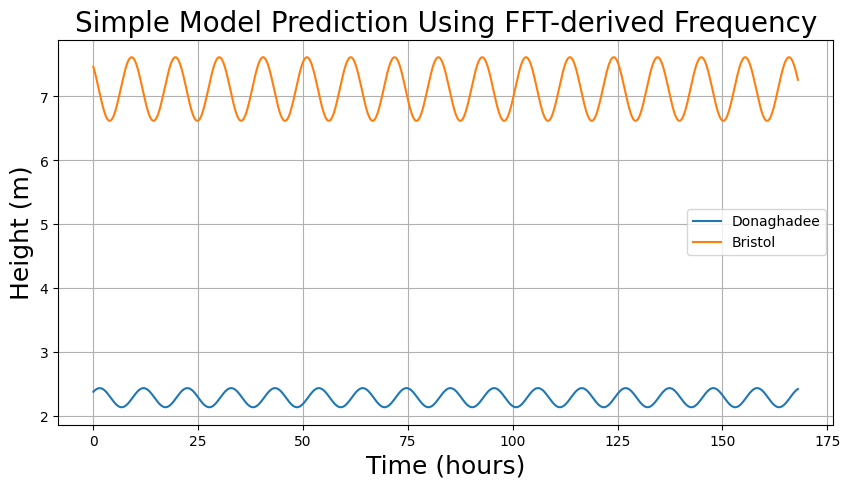

In [66]:
num_clusters = 3
tol = 0.01

# Get dominant omegas from FFT
omegas, amps, clustered_omegas = FFT(num_clusters, tol, bristol_times, bristol_heights)

omega_val = 2 * (clustered_omegas[0] - clustered_omegas[1] + clustered_omegas[2])
print(f"{omega_val:.3f} rad/hr")
print(f"{omega_val * 180 / np.pi:.3f} deg/hr")

plot_times = np.linspace(0, 168, 4000)
donaghadee_params = tide_params(donaghadee_data, omega_val)
bristol_params = tide_params(bristol_data, omega_val)

donaghadee_plots = [predicted(t, donaghadee_params, omega_val) for t in plot_times]
bristol_plots = [predicted(t, bristol_params, omega_val) for t in plot_times]

plt.figure(figsize=(10, 5))
plt.plot(plot_times, donaghadee_plots, label='Donaghadee')
plt.plot(plot_times, bristol_plots, label='Bristol')
plt.xlabel('Time (hours)', fontsize=18)
plt.ylabel('Height (m)', fontsize=18)
plt.title('Simple Model Prediction Using FFT-derived Frequency', fontsize=20)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()

Clustered omegas: [0.54656197 0.52834324 0.28239035]
34.44726350126858


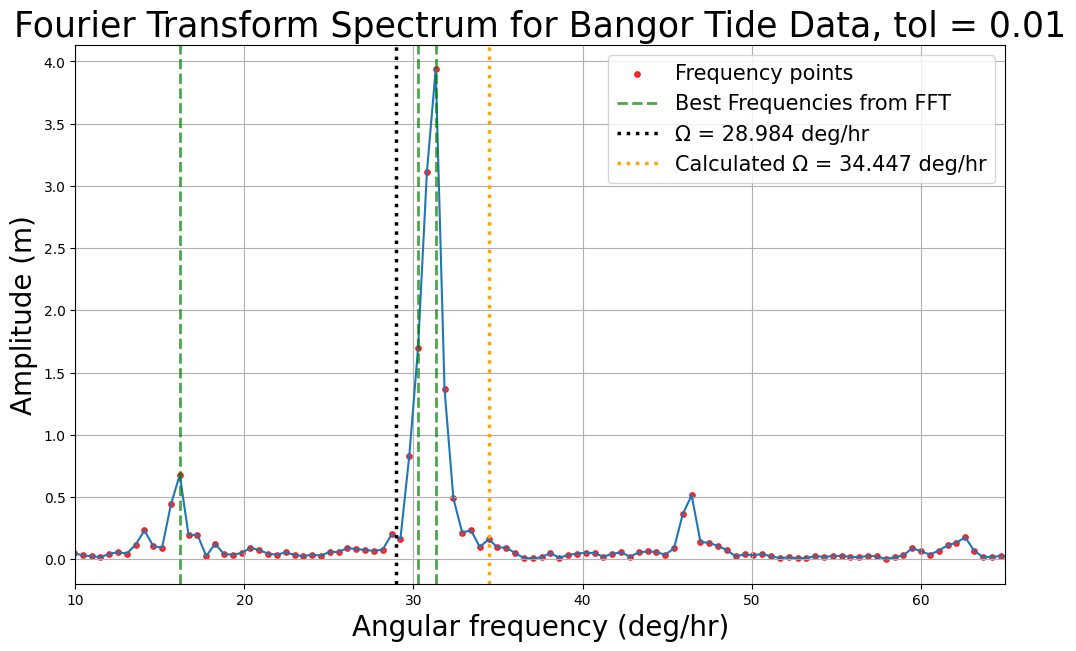

In [58]:
num_clusters = 3
tol = 0.01

omegas, amps, clustered_omegas = FFT(num_clusters, tol, bristol_times, bristol_heights)
omegas_deg = omegas * 180 / np.pi
omega_val = 2 * (clustered_omegas[0] - clustered_omegas[1] + clustered_omegas[2])
print(omega_val * 180 / np.pi)
plt.figure(figsize=(12, 7))
plt.plot(omegas_deg, amps)
plt.scatter(omegas_deg, amps, color='red', s=15, alpha=0.8, label="Frequency points")

# for omega in manual_omegas:
#     plt.axvline(x=omega * 180 / np.pi, color='red', alpha=0.6, linestyle='--' , linewidth=, label='Online omega values')
for omega in clustered_omegas:
    plt.axvline(x=omega * 180 / np.pi, color='green', alpha=0.7, linestyle='--', linewidth=2, label=f'Best Frequencies from FFT')
plt.axvline(x=OMEGA_RAD * 180 / np.pi, color='black', linestyle=':', linewidth=2.5, label='\u03A9 = 28.984 deg/hr')
plt.axvline(x=omega_val * 180 / np.pi, color='orange', linestyle=':', linewidth=2.5, label=f'Calculated \u03A9 = {omega_val * 180 / np.pi:.3f} deg/hr')
plt.xlabel("Angular frequency (deg/hr)", fontsize=20)
plt.ylabel("Amplitude (m)", fontsize=20)
plt.xlim(10, 65)
plt.title(f"Fourier Transform Spectrum for Bangor Tide Data, tol = {tol}", fontsize=25)
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=15)
plt.show()

In [ ]:
def inverseFFT(times, heights):
    # Sampling interval (hours)
    dt = 0.25

    # Number of samples
    N = len(heights)

    # Remove mean BEFORE FFT
    h0 = np.mean(heights)
    zeroed_heights = heights - h0

    # FFT of demeaned signal
    H = np.fft.rfft(zeroed_heights)

    # Frequencies
    freqs = np.fft.rfftfreq(N, d=dt)
    omega = freqs * 2 * np.pi

    # Amplitudes and phases
    amps = 2 * np.abs(H) / N
    phases = np.angle(H)
    return omega, amps, phases, h0

def prediction_fft(t):
  h = h0
  for i in top_indices:
      h += amps[i] * np.cos(omega[i] * t + phases[i])
  return h

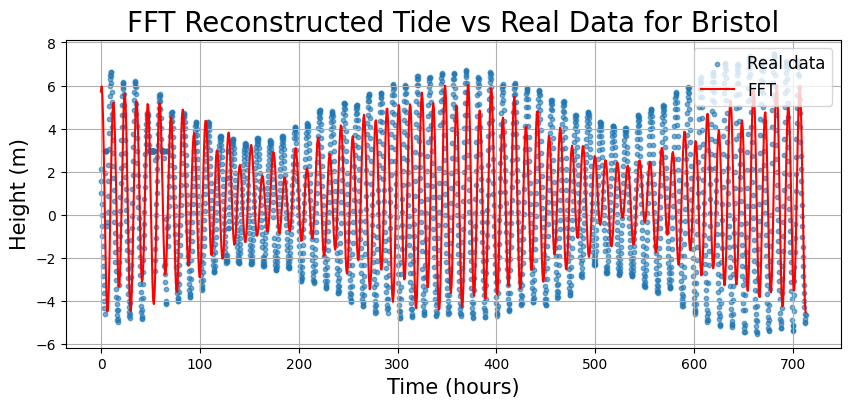

In [ ]:
omega, amps, phases, h0 = inverseFFT(bristol_times, bristol_heights)
top_indices = [np.argmin(np.abs(omega - w)) for w in clustered_omegas]

plot_times = np.linspace(bristol_times.min(), bristol_times.max(), 1000)
fft_recon = [prediction_fft(t) for t in plot_times]

plt.figure(figsize=(10, 4))
plt.scatter(bristol_times, bristol_heights, s=10, alpha=0.6, label="Real data")
plt.plot(plot_times, fft_recon, color="red", label="FFT")
plt.xlabel("Time (hours)", fontsize=15)
plt.ylabel("Height (m)", fontsize=15)
plt.title("FFT Reconstructed Tide vs Real Data for Bristol", fontsize=20)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()